<a href="https://colab.research.google.com/github/JinseoWoo/geo_ML/blob/geo_second/geo_ML_minmax_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필요 라이브러리 import

In [62]:
import pandas as pd                                          #데이터 분석 라이브러리
from sklearn.decomposition import PCA                        #주성분 분석 라이브러리
import numpy as np                                           # 계산 라이브러리
from sklearn.preprocessing import MinMaxScaler, StandardScaler    # scale 라이브러리

from sklearn.model_selection import train_test_split         # 데이터 분할 라이브러리
from sklearn.model_selection import cross_validate           # Kfold 라이브러리
from sklearn.model_selection import cross_val_score          # Kfold 라이브러리
from sklearn.model_selection import StratifiedKFold          # Kfold 라이브러리
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection

from sklearn.neighbors import KNeighborsClassifier           # KNN 라이브러리
from sklearn.svm import SVC                                  # SVM Classifier 라이브러리
from sklearn.tree import DecisionTreeClassifier              # 결정나무분류 라이브러리
from sklearn.linear_model import LogisticRegression          # 로지스틱 회귀 라이브러리
from sklearn.ensemble import RandomForestClassifier          # 랜덤 포레스트 라이브러리
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
#from bayes_opt import BayesianOptimization                   # 베이시안 라이브러리   


from sklearn.metrics import make_scorer                      # 평가용 라이브러리
from sklearn.metrics import f1_score                         # f1  라이브러리
from sklearn.metrics import accuracy_score                   # accuracy 라이브러리 



import matplotlib.pyplot as plt                              # 그래프 라이브러리
from sklearn.ensemble import VotingClassifier                # 보팅 앙상블 라이브러리
import seaborn as sns                                        # boxplot 을 위한 라이브러리
import joblib

# data 불러오기

In [2]:
from google.colab import files
uploaded = files.upload()

Saving geo_training_seq_data.csv to geo_training_seq_data.csv


In [3]:
#import pandas as pd
import io
File = pd.read_csv(io.BytesIO(uploaded["geo_training_seq_data.csv"]))

In [4]:
uploaded = files.upload()

Saving 초량동 지형 강우량.xlsx to 초량동 지형 강우량.xlsx


In [5]:
accident = pd.read_excel(io.BytesIO(uploaded["초량동 지형 강우량.xlsx"]))

In [98]:
Floodfile = File.drop(['Unnamed: 0','FLOOD'], axis = 1)  # 필요 독립변수
Floodclass = File['FLOOD']                                            # 종속 변수 

In [99]:
Floodfile.head()

,PUMP_RATIO,Hourly_Rainfall_Weight,Impervious_Surface_Weight,SLOPE_AVG_Weight,HIGH_Weight,F_WEIGHT
0,4.115226e-07,0.104348,0.467342,0.599952,0.045968,0.075019
1,4.115226e-07,0.208696,0.467342,0.599952,0.045968,0.075019
2,4.115226e-07,0.259722,0.467342,0.599952,0.045968,0.075019
3,4.115226e-07,0.010870,0.467342,2.699784,0.072218,0.075019
4,4.115226e-07,0.108696,0.467342,2.699784,0.072218,0.075019


In [100]:
Floodclass.head()

0    0
1    0
2    1
3    0
4    1
Name: FLOOD, dtype: int64

# Standardscaler
## data scale 과정

In [101]:
Floodfile1 = Floodfile.copy()
scaler = MinMaxScaler()
scaler.fit(Floodfile1)
Floodfile1 = scaler.transform(Floodfile1)  # data sclae 과정 -> minmaxscaler 를 통해 0~1의 값으로 변환

In [102]:
pca = PCA(n_components=4)  # 주성분 분석 후 -> 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(Floodfile1)  
Floodfile1 = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2','principal component3', 'principal component4'])
# pca를 통해 나온 4가지 주성분을 독립변수로 사용하도록 데이터 변형

# data split
## 8 : 2 으로 training 과 test 구분

In [103]:
x_train, x_test, y_train, y_test = train_test_split(Floodfile1, Floodclass , test_size=0.2, random_state=42)

In [104]:
ran = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
log = LogisticRegression()
xgb = XGBClassifier()
gbc = GradientBoostingClassifier()
svc = SVC(probability=True)
ext = ExtraTreesClassifier()
ada = AdaBoostClassifier()
gnb = GaussianNB()
gpc = GaussianProcessClassifier()
bag = BaggingClassifier()

# 리스트 준비
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]         
model_names = ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'AdaBoost', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier']
scores = {}

# 이어서 연속적으로 모델을 학습 시키고 교차 검증합니다.
for ind, mod in enumerate(models):
    mod.fit(x_train, y_train)
    f1_s = cross_val_score(mod, x_train, y_train, scoring = make_scorer(f1_score), cv = 10)
    scores[model_names[ind]] = f1_s

skfolds=StratifiedKFold(n_splits=5, random_state=42 ,shuffle = True)

# 베이지안최적화과정에서 Kfold 를 사용하기위해 설정

In [105]:
results = pd.DataFrame(scores).T
results['mean'] = results.mean(1)

result_df = results.sort_values(by='mean', ascending=False)#.reset_index()
result_df.head(11)

,0,1,2,3,4,5,6,7,8,9,mean
Random Forest,0.681818,0.745098,0.745098,0.782609,0.775510,0.833333,0.571429,0.731707,0.720000,0.652174,0.723878
Bagging Classifier,0.727273,0.693878,0.693878,0.808511,0.760000,0.808511,0.619048,0.564103,0.708333,0.681818,0.706535
XGBoost,0.585366,0.695652,0.792453,0.681818,0.782609,0.844444,0.536585,0.731707,0.692308,0.666667,0.700961
Gradient Boosting,0.619048,0.680851,0.784314,0.755556,0.760000,0.800000,0.523810,0.700000,0.693878,0.681818,0.699927
Extra Trees,0.681818,0.720000,0.745098,0.755556,0.750000,0.791667,0.536585,0.600000,0.734694,0.666667,0.698208
AdaBoost,0.666667,0.723404,0.777778,0.681818,0.666667,0.791667,0.558140,0.714286,0.666667,0.636364,0.688346
SVC,0.650000,0.666667,0.782609,0.619048,0.744186,0.744186,0.650000,0.650000,0.680851,0.631579,0.681913
K Nearest Neighbour,0.590909,0.652174,0.680000,0.808511,0.679245,0.755556,0.636364,0.682927,0.627451,0.636364,0.674950
Gaussian Process,0.571429,0.529412,0.761905,0.564103,0.590909,0.714286,0.488889,0.666667,0.608696,0.615385,0.611168
Gaussian Naive Bayes,0.550000,0.473684,0.765957,0.536585,0.638298,0.600000,0.510638,0.578947,0.625000,0.615385,0.589450


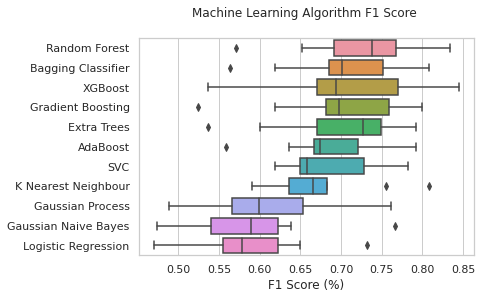

In [106]:
result_df = result_df.drop(['mean'], axis=1)
sns.boxplot(data=result_df.T, orient='h')
plt.title('Machine Learning Algorithm F1 Score \n')
plt.xlabel('F1 Score (%)');


In [107]:
def importance_plotting(data, xlabel, ylabel, title, n=20):
    sns.set(style="whitegrid")
    ax = data.tail(n).plot(kind='barh')
    
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    plt.show()

In [109]:
fi = {'Features':Floodfile1.columns.tolist(), 'Importance':xgb.feature_importances_}
importance = pd.DataFrame(fi, index=fi['Features']).sort_values('Importance', ascending=True)

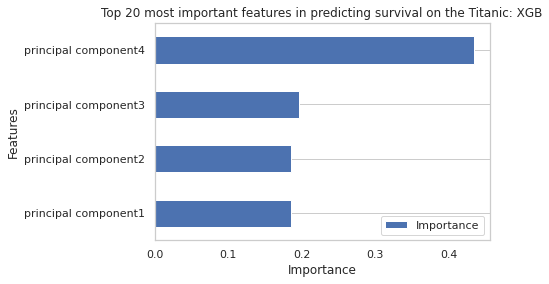

In [110]:
# 그래프 제목
title = 'Top 20 most important features in predicting survival on the Titanic: XGB'

# 그래프 그리기
importance_plotting(importance, 'Importance', 'Features', title, 20)


# SVM

In [111]:
Cs = [0.01, 0.1, 1, 5, 10, 15, 20, 50]
gammas = [0.001, 0.01, 0.1]

# 파라미터 그리드 셋팅
hyperparams = {'C': Cs, 'gamma' : gammas}

# 교차검증
gd=GridSearchCV(estimator = SVC(probability=True), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = make_scorer(f1_score), n_jobs=-1)

# 모델 fiting 및 결과
gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.9s


0.6464974816774909
{'C': 50, 'gamma': 0.1}


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    5.6s finished


In [112]:
Cs = [50]
gammas = [0.1]

# 파라미터 그리드 셋팅
hyperparams = {'C': Cs, 'gamma' : gammas}

# 교차검증
gd=GridSearchCV(estimator = SVC(probability=True), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = make_scorer(f1_score), n_jobs=-1)

# 모델 fiting 및 결과
gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.6464974816774909
{'C': 50, 'gamma': 0.1}


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


# Gradient Boosting Classifier

In [113]:
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.5]
n_estimators = [100, 1000, 2000]
max_depth = [3, 5, 10, 15]

hyperparams = {'learning_rate': learning_rate, 'n_estimators': n_estimators, 'max_depth':max_depth }

gd=GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = make_scorer(f1_score), n_jobs=-1)

gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.7min finished


0.7195890481363606
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}


# Logistic Regression

In [114]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

hyperparams = {'penalty': penalty, 'C': C}

gd=GridSearchCV(estimator = LogisticRegression(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = make_scorer(f1_score), n_jobs=-1)

gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.5990745688420107
{'C': 21.544346900318832, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


# XGBoost

In [115]:
learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
n_estimators = [10, 50, 100, 250, 500, 1000]

hyperparams = {'learning_rate': learning_rate, 'n_estimators': n_estimators}

gd=GridSearchCV(estimator = XGBClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = make_scorer(f1_score), n_jobs=-1)

gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:   13.1s


0.7201914353229072
{'learning_rate': 0.1, 'n_estimators': 250}


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   15.3s finished


In [116]:
max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
min_child_weight = [1, 2, 3, 4, 5, 6]

hyperparams = {'max_depth': max_depth, 'min_child_weight': min_child_weight}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=250), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = make_scorer(f1_score), n_jobs=-1)

gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    6.8s


0.7142680934538186
{'max_depth': 3, 'min_child_weight': 5}


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   21.4s finished


In [117]:
gamma = [i*0.1 for i in range(0,5)]

hyperparams = {'gamma': gamma}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=250, max_depth=3, 
                                          min_child_weight=1), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = make_scorer(f1_score), n_jobs=-1)

gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.7167493796526054
{'gamma': 0.1}


[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.7s finished


In [118]:
subsample = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
colsample_bytree = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    
hyperparams = {'subsample': subsample, 'colsample_bytree': colsample_bytree}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=250, max_depth=3, 
                                          min_child_weight=1, gamma=0), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = make_scorer(f1_score), n_jobs=-1)

gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 402 out of 405 | elapsed:   24.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   24.7s finished


0.718529899136594
{'colsample_bytree': 0.6, 'subsample': 0.65}


In [119]:
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
    
hyperparams = {'reg_alpha': reg_alpha}
gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, n_estimators=250, max_depth=3, 
                                          min_child_weight=1, gamma=0,subsample=0.95, colsample_bytree=0.85), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = make_scorer(f1_score), n_jobs=-1)

gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.7126129217896148
{'reg_alpha': 0.1}


[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.5s finished


# Gaussian Process

In [120]:
n_restarts_optimizer = [0, 1, 2, 3]
max_iter_predict = [1, 2, 5, 10, 20, 35, 50, 100]
warm_start = [True, False]

hyperparams = {'n_restarts_optimizer': n_restarts_optimizer, 'max_iter_predict': max_iter_predict, 'warm_start': warm_start}

gd=GridSearchCV(estimator = GaussianProcessClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = make_scorer(f1_score), n_jobs=-1)

gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:   10.1s


0.602872053419798
{'max_iter_predict': 2, 'n_restarts_optimizer': 0, 'warm_start': True}


[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   23.3s finished


# AdaBoost

In [121]:
n_estimators = [80,90,100,110]
learning_rate = [1.3,1.4,1.5, 1.6]

hyperparams = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

gd=GridSearchCV(estimator = AdaBoostClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = make_scorer(f1_score), n_jobs=-1)

gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.7s


0.7051521460694337
{'learning_rate': 1.4, 'n_estimators': 110}


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.9s finished


# KNN

In [122]:
n_neighbors = [7,8,10,11,12]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = [1, 2, 3, 4, 5, 10]

hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}

gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = make_scorer(f1_score), n_jobs=-1)

# Fitting model and return results
gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.7210393881892934
{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 10, 'weights': 'distance'}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.9s finished


# Random Forest

In [123]:
n_estimators = [8,9,10,11]
max_depth = [3,4,5,None]
max_features = [0.4, 0.5, 0.6]
min_samples_split = [2,3,4]
min_samples_leaf = [2,3,4]

hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

gd=GridSearchCV(estimator = RandomForestClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = make_scorer(f1_score), n_jobs=-1)

gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 1764 tasks      | elapsed:   31.0s


0.7309214417006313
{'max_depth': None, 'max_features': 0.6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}


[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:   38.5s finished


# Extra Tree

In [124]:
n_estimators = [20, 23, 25, 30]
max_depth = [3,4,5, None]
max_features = [0.6,0.7,0.8,0.9,1]
min_samples_split = [8,9,10,11]
min_samples_leaf = [2,3,4]

hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

gd=GridSearchCV(estimator = ExtraTreesClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = make_scorer(f1_score), n_jobs=-1)

gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 1764 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 3164 tasks      | elapsed:  1.4min


0.713718402478993
{'max_depth': None, 'max_features': 0.8, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 30}


[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  2.2min finished


# Bagging Classifier

In [125]:
n_estimators = [70,73,75,77]
max_samples = [0.9, 1.0, 1.1]
max_features = [0.9, 1.0, 1.1]

hyperparams = {'n_estimators': n_estimators, 'max_samples': max_samples, 'max_features': max_features}

gd=GridSearchCV(estimator = BaggingClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = make_scorer(f1_score), n_jobs=-1)

gd.fit(x_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.3s


0.7269742585807645
{'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 75}


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   11.1s finished


In [126]:
svc = SVC(probability=True, gamma=0.1, C=10, random_state=1)

gbc = GradientBoostingClassifier(learning_rate=0.5, max_depth=3, n_estimators=100, random_state=1)

log = LogisticRegression(C=7.742636826811269, penalty='l2', random_state=1 ,n_jobs=-1)

xgb = XGBClassifier(learning_rate=0.2, n_estimators=250, max_depth=3, 
                    min_child_weight=1, gamma=0.0, subsample=0.95, colsample_bytree=0.85, reg_alpha=0.01)

gpc = GaussianProcessClassifier(max_iter_predict=2, n_restarts_optimizer=0, warm_start=True, random_state=1, n_jobs=-1)

ada = AdaBoostClassifier(learning_rate=1.5, n_estimators=90, random_state=1)

knn = KNeighborsClassifier(leaf_size=1, n_neighbors=7, weights='distance',n_jobs=-1)

ran = RandomForestClassifier(max_depth=None, max_features=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=10, random_state=1, n_jobs=-1)

ext = ExtraTreesClassifier(max_depth=None, max_features=0.9, min_samples_leaf=2, min_samples_split=9, n_estimators=23, random_state=1, n_jobs=-1)

bag = BaggingClassifier(max_features=1.0, max_samples=1.0, n_estimators=77, random_state=1,n_jobs=-1)

# 리스트
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]         
model_names = ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'AdaBoost', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier']
scores3 = {}

# Sequentially fit and cross validate all models
for ind, mod in enumerate(models):
    mod.fit(x_train, y_train)
    f1_s = cross_val_score(mod, x_train, y_train, scoring = make_scorer(f1_score), cv = 10)
    scores3[model_names[ind]] = f1_s

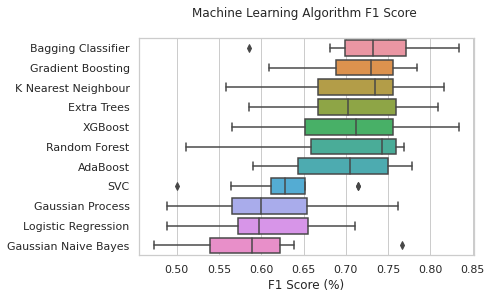

In [127]:
results = pd.DataFrame(scores3).T
results['mean'] = results.mean(1)
result_df = results.sort_values(by='mean', ascending=False)
result_df.head(11)


result_df = result_df.drop(['mean'], axis=1)
sns.boxplot(data=result_df.T, orient='h')
plt.title('Machine Learning Algorithm F1 Score \n')
plt.xlabel('F1 Score (%)');

In [128]:
grid_soft = VotingClassifier(estimators = [('Random Forest', ran), 
                                           ('Logistic Regression', log),
                                           ('XGBoost', xgb),
                                           ('Gradient Boosting', gbc),
                                           ('Extra Trees', ext),
                                           ('AdaBoost', ada),
                                           ('Gaussian Process', gpc),
                                           ('SVC', svc),
                                           ('K Nearest Neighbour', knn),
                                           ('Bagging Classifier', bag)], voting = 'soft')

grid_soft_cv = model_selection.cross_validate(grid_soft, x_train, y_train, cv=10, scoring=make_scorer(f1_score))
grid_soft.fit(x_train, y_train)

print("Soft voting on test set score mean: {:.2f}". format(grid_soft_cv['test_score'].mean() * 100))

Soft voting on test set score mean: 70.35


In [129]:
# voting 결과 값들
grid_soft_cv

{'fit_time': array([0.89706635, 0.86436558, 0.86284566, 0.8266108 , 0.86809635,
        0.81391621, 0.83280706, 0.7988379 , 0.78388309, 0.80961347]),
 'score_time': array([0.3646884 , 0.38351393, 0.37815571, 0.39860106, 0.36980772,
        0.35903549, 0.38024521, 0.38499117, 0.36916041, 0.36199832]),
 'test_score': array([0.66666667, 0.76595745, 0.76      , 0.72727273, 0.73469388,
        0.83333333, 0.58536585, 0.63157895, 0.69387755, 0.63636364])}

In [130]:
# Voting으로 predict하기
y_pred = grid_soft.predict(x_test)

In [131]:
# 결과 값
print('Voting',f1_score(y_test,y_pred)) 

Voting 0.6981132075471698


# 2020 년 사고사례 데이터

In [132]:
Busanaccident = accident.drop(['SLOPE_L','SLOPE_H','FLOOD','MANHOLES_RATIO'], axis = 1)  # 불필요 컬럼제거
Busanaccidentclass = accident['FLOOD']                                                   # 종속 변수 

Busanaccident.rename(columns={'R_W_SUM':'Hourly_Rainfall_Weight','HOUR_RAINFALL':'Hourly_Rainfall','IMP_SUR_RATIO':'Impervious_Surface',
                              'IMP_W_SUM':'Impervious_Surface_Weight'},inplace=True)  
#가중치 적용을 위해 컬럼명 수정하여 사용

Busanaccident['SLOPE_AVG'] = Busanaccident['SLOPE_AVG'].astype(float)
Busanaccident['HIGH'] = Busanaccident['HIGH'].astype(float)

rain_weight = Busanaccident['Hourly_Rainfall'].copy()
imp_weight = Busanaccident['Impervious_Surface'].copy()
slope_weight = Busanaccident['SLOPE_AVG'].copy()
high_weight = Busanaccident['HIGH'].copy()




## 강우량 가중치

for idx,col in enumerate(Busanaccident['Hourly_Rainfall']):
    if col <= 15:
        rain_weight[idx] = col / (46)
    elif col > 15 and col <= 35:
        rain_weight[idx] = col / (18 * 2**2)
    elif col > 35 and col <= 60:
        rain_weight[idx] = col / (17 * 3**2)
    elif col > 60 and col <= 80:
        rain_weight[idx] = col / (11 * 4**2)
    elif col > 80:
        rain_weight[idx] = col / (6.28 * 5**2)

## 불투수면 가중치

for idx,col in enumerate(Busanaccident['Impervious_Surface']):
    if col <= 15:
        imp_weight[idx] = col / 6.66
    elif col > 15 and col <= 25:
        imp_weight[idx] = col / (20 * 2)
    elif col > 25 and col <= 40:
        imp_weight[idx] = col / (13.33 * 3)
    elif col > 40 and col <= 55:
        imp_weight[idx] = col / (33.33 * 4)
    elif col > 55:
        imp_weight[idx] = col / (26.67 * 5)

## 경사도 가중치

#Busanaccident['SLOPE_AVG_Weight'] = Busanaccident['SLOPE_AVG']

for idx,col in enumerate(Busanaccident['SLOPE_AVG']):
    if col <= 10:
        slope_weight[idx] = col / (41.67 / 5**2 )
    elif col > 10 and col <= 15:
        slope_weight[idx] = col / (25 / 4**2)
    elif col > 15 and col <= 25:
        slope_weight[idx] = col / (16.67 / 3**2)
    elif col > 25 and col <= 50:
        slope_weight[idx] = col / (8.33 / 2**2)
    elif col > 50:
        slope_weight[idx] = col / (8.33 / 1**2)

## 고도 가중치

#Busanaccident['HIGH_Weight'] = Busanaccident['HIGH']

for idx,col in enumerate(Busanaccident['HIGH']):
    if col <= 20:
        high_weight[idx] = col / (79.62 / 1**2)
    elif col > 20 and col <= 40:
        high_weight[idx] = col / (10.18 / 2**2)
    elif col > 40 and col <= 60:
        high_weight[idx] = col / (4.63 / 3**2)
    elif col > 60 and col <= 80:
        high_weight[idx] = col / (2.78 / 4**2)
    elif col > 80:
        high_weight[idx] = col / (2.78 / 5**2)

slope_weight

Busanaccident['Hourly_Rainfall_Weight'] = rain_weight
Busanaccident['Impervious_Surface_Weight'] = imp_weight
Busanaccident['SLOPE_AVG_Weight'] = slope_weight
Busanaccident['HIGH_Weight'] = high_weight


## 가중치 값을 구한뒤 불필요한 변수 다시 제거

Busanaccident = Busanaccident.drop(['SLOPE_AVG','Impervious_Surface','Hourly_Rainfall','HIGH'], axis = 1)

Busanaccident

Busanaccident = Busanaccident[['Hourly_Rainfall_Weight','Impervious_Surface_Weight','SLOPE_AVG_Weight','HIGH_Weight','F_WEIGHT','PUMP_RATIO']]

In [133]:
Busanaccident.head()

,Hourly_Rainfall_Weight,Impervious_Surface_Weight,SLOPE_AVG_Weight,HIGH_Weight,F_WEIGHT,PUMP_RATIO
0,0.00000,0.434346,0.599952,0.050239,0.017,1.982160e-07
1,0.00000,0.434346,0.599952,0.050239,0.017,1.982160e-07
2,0.00000,0.434346,0.599952,0.050239,0.017,1.982160e-07
3,0.00000,0.434346,0.599952,0.050239,0.017,1.982160e-07
4,0.01087,0.434346,0.599952,0.050239,0.017,1.982160e-07


## 정리된 데이터에 scale 적용

In [134]:
scaler = MinMaxScaler()
scaler.fit(Busanaccident)
Busanaccident = scaler.transform(Busanaccident)                         # sccler 적용

In [135]:
pca = PCA(n_components=4)
printcipalComponents = pca.fit_transform(Busanaccident)
Busanaccident = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2','principal component3', 'principal component4'])

## 초량동에 대한 예측 실시


In [136]:
accident_predict= grid_soft.predict(Busanaccident)                       # 학습된 모델을 활용해 사고사례 예측 실시

In [137]:
print(accident_predict)                                                 # 예측값 확인

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [97]:
#joblib.dump(ensemble, '../../Data/final_data/model/geo_model/ensemble.pkl')
#joblib.dump(ensemble, '../../Web/ensemble.pkl')